# Car brand classification report

## Summary

1. [Introduction](#introduction)
2. [Data analysis](#dataanalysis)
    1. [Exploring the subject](#2.1)
    2. [Generating the dataset](#2.2)
    3. [Data exploration & analysis](#2.3)
3. [Data preprocessing](#datapreprocessing)
    1. [Split train & validation set](#3.1)
    2. [Label encoding & data prep](#3.2)
4. [First neural network training](#4)
    1. [Linear classification](#4.1)
    2. [Multi Layer Pereceptron](#4.2)
    3. [Support Vector Machine](#4.3)
    4. [Convolutional Neural Network](#4.4)
6. [Prediction & submissions](#6)
    1. [Predict & submit results](#6.1)
7. [Conclusion](#ccl)

<a id="introduction"></a>
## 1. Introduction

This report aims to explain how te evaluate various model for a same problematic : **Car brand prediction with an image dataset**.
We'll be exploring various models and training various one te interpret which one is the most accurate. Then we'll explain intuition that led us to several way to imrove data and therefore the **model**.

The best model we manage to produce had an **A FAIRE** accuracy.

This notebook contains three four part:
* Data analysis
* Data preprocessing
* First neural networks training and evaluation
* Neural network and data improvement


<a id="dataanalysis"></a>
## 2. Data analysis

This part will describe how the data was scrapped and generated and also will be explored to know the repartition of each car brand in the dataset.

<a id="2.1"></a>
### 2.1 Exploring the subject

**First approach**
First of all, in order to retrieve numerous images of a car from a specific brand we decide to create a bot to scrap google images with search such as 'audi front' or 'mercedes'.

The results were not good with too many unrevelant photos and bad quality:

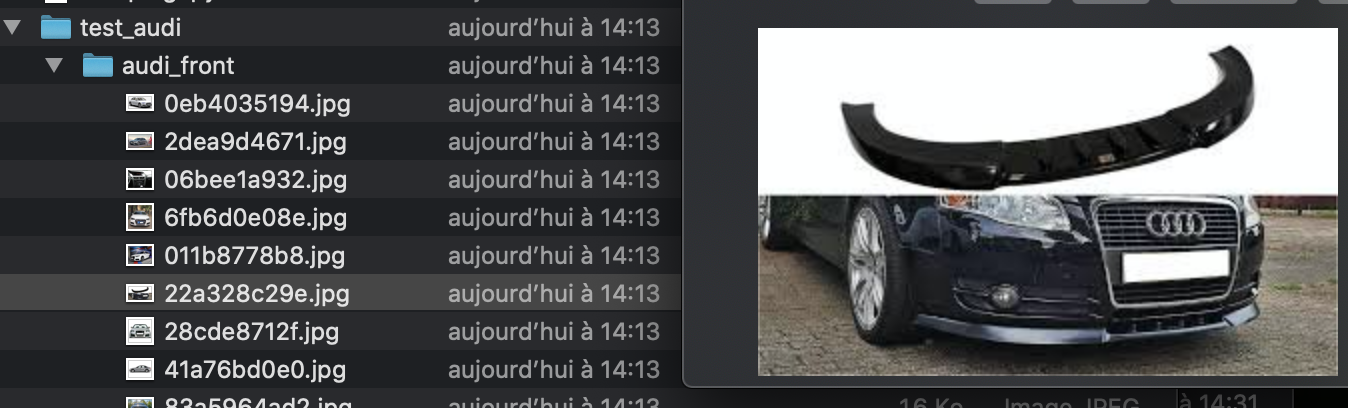

In [1]:
#
# Firstly we import necessary libs
#
import selenium
import os
import io
import time
import requests
import hashlib
from PIL import Image
from selenium import webdriver
DRIVER_PATH = '../../chromedriver' # might need a different version of chromedriver depending on OS or chrome version


#
# Fetch all images url's from a specific gogole search
#

def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

#
# Utility function to save images form url in a folder
#

def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")
        
#
# Combine fetch url and save image utility functions into a more practical to use function
#

def search_and_download(search_term:str,driver_path:str,target_path='./images',number_images=5):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
        
    for elem in res:
        persist_image(target_folder,elem)

# Example of usage => search_and_download('audi front', DRIVER_PATH, './dataset', 60)

<a id="2.2"></a>
### 2.2 Generating the dataset

**Second approach**

From then on we wanted to base ourselves on the images of the car ad site.
By dint of searching we found the site carizy.com which offered a strong formalised layout for pictures.
By studying the site we found that the photos were hosted on a CDN with a formalised structure for each angle (front hood).
So we set up a script to retrieve quality images on the brands we wanted with the right angle. By doing so we could iterate over brands and also over angles of the car.

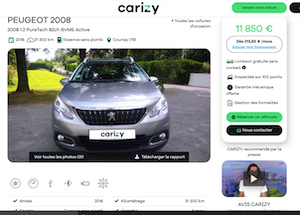

In [5]:
#
# Import necessary dependencies
#
import time
import requests
import os
import io
from PIL import Image #pip install Pillow
import hashlib

#
# Define a car data class that retrieve the useful data
#

class CarData:
    def __init__(self, car_id, url, img):
        self.car_id = car_id
        self.url = url
        self.img = img
        
    def __repr__(self):
        return str(self.car_id) + " : " + self.url + ' + ' + self.img
    
#
# Request the search api of the website with good params
#

def send_algolia_request(page):
    url = 'https://65quub6n61-dsn.algolia.net/1/indexes/*/queries?x-algolia-agent=Algolia%20for%20vanilla%20JavaScript%20(lite)%203.18.1%3Binstantsearch.js%201.8.11&x-algolia-application-id=65QUUB6N61&x-algolia-api-key=9ce4fd3eb414de32d0985b9b5a394448'
    data = {'requests': [{'indexName' : 'CarAlgoliaIndex_prod', 'params': 'query=&hitsPerPage=21&maxValuesPerFacet=100&page='+ str(page) +'&facets=%5B%22make%22%2C%22model%22%2C%22body%22%2C%22registartionDate%22%2C%22color%22%2C%22gear%22%2C%22fuel%22%2C%22price%22%2C%22monthly%22%2C%22kilometers%22%2C%22district%22%2C%22districtName%22%2C%22city%22%2C%22seats%22%2C%22isScrapPremium%22%5D&tagFilters='}]}
    p = requests.post(url, json=data)
    return p.json()

#
# map data to keep only useful data
#

def map_data(_car_data, hits):
    for e in hits:
        if e['make'] in _car_data:
            _car_data[e['make']].append(CarData(e['carId'], e['lien'], e['photo']))
        else:
            _car_data[e['make']] = [CarData(e['carId'], e['lien'], e['photo'])]

#
# Make all the request with a interval to avoid api blocking
#            
            
car_data = {}
i = 0
while i < 48:
    x = send_algolia_request(i)
    map_data(car_data, x['results'][0]['hits'])
    i += 1
    time.sleep(1)
   


#
# Utility function to download the images
#

def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")
 
#
# Final function that takes brand and angle paramaters
#

def download_brand_angle_img(brand, angle, folder):
    urls = []
    folder_url = folder
    for x in car_data[brand]:
        
        ur = x.img.replace('avant-gauche', angle)
        finalurl = 'https://cdn.carizy.com/carphotos/' + str(x.car_id) + '/wide/' + ur
        urls.append(finalurl)
    
    for z in urls:
        persist_image(folder_url, z)
        time.sleep(0.2)
# Folder must be already created
#Example of usage => download_brand_angle_img('AUDI', 'face-capot', './cars')


<div class="alert alert-block alert-info">
    We will know download raw data for three brands in the folder raw of the project structure.
</div

In [6]:
download_brand_angle_img('PEUGEOT', 'face-capot', '../../Dataset/Raw/peugeot')

SUCCESS - saved https://cdn.carizy.com/carphotos/34181/wide/peugeot-208-occasion-2013-face-capot.jpg - as ../../Dataset/Raw/peugeot/e9a67e5138.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34178/wide/peugeot-207-occasion-2009-face-capot.jpg - as ../../Dataset/Raw/peugeot/1248cc9ae4.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34159/wide/peugeot-308-sw-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/peugeot/89c230f83c.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34121/wide/peugeot-2008-occasion-2014-face-capot.jpg - as ../../Dataset/Raw/peugeot/eb0df16501.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34115/wide/peugeot-208-business-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/peugeot/0ae37dc63a.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34105/wide/peugeot-208-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/peugeot/cb4c6c2ad2.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34100/wide/peugeot-3008-occasion-2015-face-capot.jpg - a

SUCCESS - saved https://cdn.carizy.com/carphotos/13540/wide/peugeot-2008-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/peugeot/6a4b401514.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13522/wide/peugeot-308-occasion-2018-face-capot.jpg - as ../../Dataset/Raw/peugeot/b6cc0518ea.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13516/wide/peugeot-2008-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/peugeot/29e13d9ee0.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13493/wide/peugeot-308-cc-occasion-2011-face-capot.jpg - as ../../Dataset/Raw/peugeot/2ef6c7f896.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13462/wide/peugeot-308-sw-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/peugeot/fb1da3aa7d.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13455/wide/peugeot-208-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/peugeot/dcecb552c1.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13434/wide/peugeot-3008-hybrid4-occasion-2012-face-capot.jpg 

SUCCESS - saved https://cdn.carizy.com/carphotos/33921/wide/peugeot-208-occasion-2019-face-capot.jpg - as ../../Dataset/Raw/peugeot/7c6e14068c.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33854/wide/peugeot-308-cc-occasion-2012-face-capot.jpg - as ../../Dataset/Raw/peugeot/21985dd629.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33874/wide/peugeot-308-cc-occasion-2011-face-capot.jpg - as ../../Dataset/Raw/peugeot/11d22140ff.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33848/wide/peugeot-308-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/peugeot/a64466e144.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33778/wide/peugeot-308-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/peugeot/1a6ee2e55f.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/32619/wide/peugeot-308-sw-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/peugeot/4f76de5fad.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/32615/wide/peugeot-208-occasion-2016-face-capot.jpg - as ../

In [7]:
download_brand_angle_img('RENAULT', 'face-capot', '../../Dataset/Raw/renault')

SUCCESS - saved https://cdn.carizy.com/carphotos/34170/wide/renault-twingo-iii-occasion-2014-face-capot.jpg - as ../../Dataset/Raw/renault/d6d4ce5cf6.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34165/wide/renault-twingo-ii-occasion-2012-face-capot.jpg - as ../../Dataset/Raw/renault/319aff485d.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34109/wide/renault-twingo-ii-occasion-2010-face-capot.jpg - as ../../Dataset/Raw/renault/5990986b51.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34158/wide/renault-captur-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/renault/f065264b39.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34157/wide/renault-captur-occasion-2013-face-capot.jpg - as ../../Dataset/Raw/renault/ffafed7e16.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34141/wide/renault-twingo-iii-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/30f8dd49c4.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34107/wide/renault-twingo-ii-occasion

SUCCESS - saved https://cdn.carizy.com/carphotos/33843/wide/renault-twingo-ii-occasion-2008-face-capot.jpg - as ../../Dataset/Raw/renault/4b2a753403.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33841/wide/renault-zoe-occasion-2020-face-capot.jpg - as ../../Dataset/Raw/renault/e0f4b16bf8.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33834/wide/renault-clio-iv-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/renault/bbe44eb235.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33831/wide/renault-clio-iv-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/0f29174768.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33823/wide/renault-twingo-ii-occasion-2010-face-capot.jpg - as ../../Dataset/Raw/renault/fdf3558840.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33818/wide/renault-captur-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/renault/ed1eb73e53.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33814/wide/renault-espace-v-occasion-2015-face

SUCCESS - saved https://cdn.carizy.com/carphotos/12792/wide/renault-scenic-iii-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/renault/d753493f33.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12784/wide/renault-megane-iv-berline-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/renault/a01a2d86b7.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12782/wide/renault-clio-iv-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/renault/d978d63239.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12687/wide/renault-scenic-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/701935ae37.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12582/wide/renault-clio-iv-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/43e8584179.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12718/wide/renault-captur-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/renault/e6f84fe403.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/12632/wide/renault-twingo-iii-occa

SUCCESS - saved https://cdn.carizy.com/carphotos/30966/wide/renault-fluence-occasion-2010-face-capot.jpg - as ../../Dataset/Raw/renault/64d75dc8c8.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/29958/wide/renault-megane-iii-berline-occasion-2011-face-capot.jpg - as ../../Dataset/Raw/renault/05385f695f.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/29928/wide/renault-captur-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/renault/8b0069ee46.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/29140/wide/renault-clio-iv-estate-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/87a7757d08.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/29133/wide/renault-clio-iv-occasion-2016-face-capot.jpg - as ../../Dataset/Raw/renault/8abd4f6297.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/28823/wide/renault-twingo-ii-occasion-2014-face-capot.jpg - as ../../Dataset/Raw/renault/a72aa58cf9.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/28817/wide/renault-twingo-

In [8]:
download_brand_angle_img('VOLKSWAGEN', 'face-capot', '../../Dataset/Raw/volkswagen')

SUCCESS - saved https://cdn.carizy.com/carphotos/34169/wide/volkswagen-golf-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/volkswagen/8018693f4f.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33959/wide/volkswagen-polo-occasion-2014-face-capot.jpg - as ../../Dataset/Raw/volkswagen/0b052bc4ad.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34029/wide/volkswagen-golf-occasion-2015-face-capot.jpg - as ../../Dataset/Raw/volkswagen/967cca70b5.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/34031/wide/volkswagen-tiguan-occasion-2014-face-capot.jpg - as ../../Dataset/Raw/volkswagen/123284bb07.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33990/wide/volkswagen-touran-occasion-2012-face-capot.jpg - as ../../Dataset/Raw/volkswagen/f8b23173c9.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/33973/wide/volkswagen-golf-occasion-2011-face-capot.jpg - as ../../Dataset/Raw/volkswagen/81378faff0.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/32855/wide/volkswagen-t

SUCCESS - saved https://cdn.carizy.com/carphotos/29948/wide/volkswagen-tiguan-occasion-2012-face-capot.jpg - as ../../Dataset/Raw/volkswagen/7d25477ac8.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/28386/wide/volkswagen-up-occasion-2018-face-capot.jpg - as ../../Dataset/Raw/volkswagen/b4449584ec.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/27632/wide/volkswagen-polo-occasion-2017-face-capot.jpg - as ../../Dataset/Raw/volkswagen/9fbcd79385.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13571/wide/volkswagen-polo-occasion-2018-face-capot.jpg - as ../../Dataset/Raw/volkswagen/14e0fc376a.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13532/wide/volkswagen-polo-occasion-2018-face-capot.jpg - as ../../Dataset/Raw/volkswagen/93a7d41ee4.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13446/wide/volkswagen-golf-occasion-2010-face-capot.jpg - as ../../Dataset/Raw/volkswagen/b48c39228c.jpg
SUCCESS - saved https://cdn.carizy.com/carphotos/13520/wide/volkswagen-golf-

Now we have a qualified dataset with lot of pictures ready to be trated.

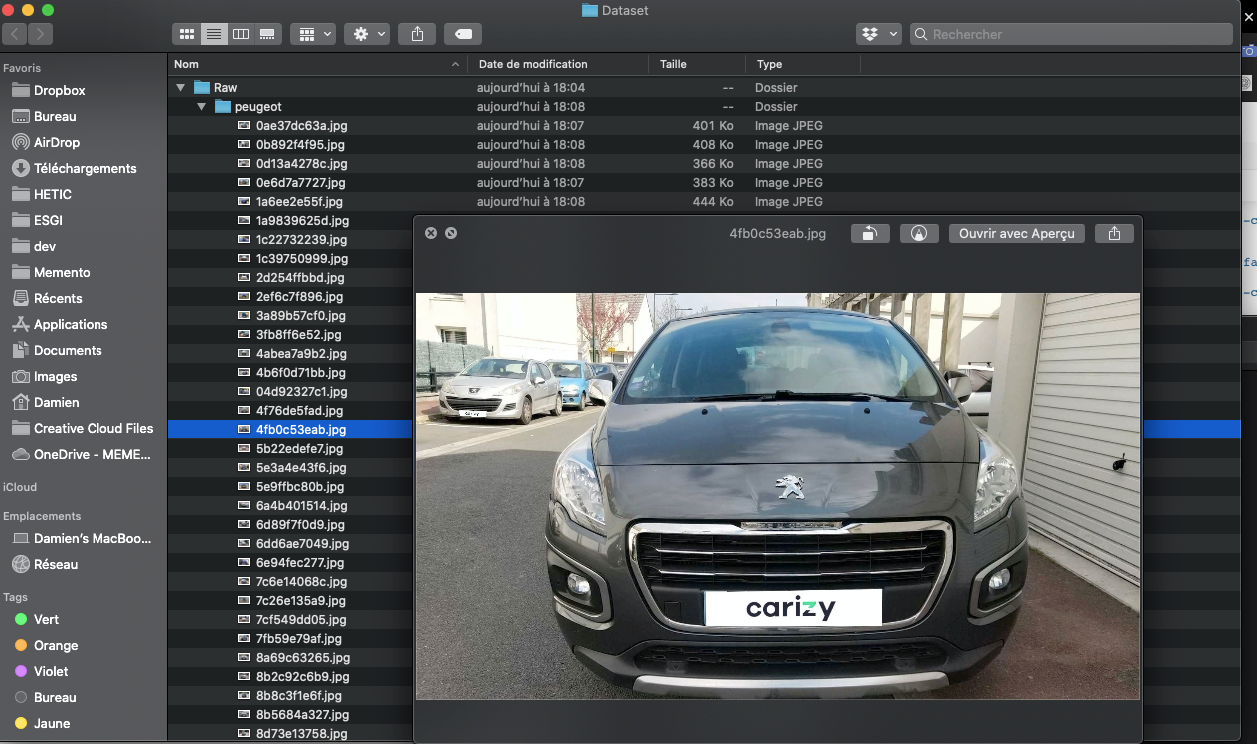

<a id="2.3"></a>
### 2.3 Data exploration & analysis

In this part we will be exploring our dataset and analyze the repartition of each brand in order to be able to evaluate the accurcay of our future model.

In [1]:
# Firstly import all important libraries even for further work
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
import tensorflow.keras.preprocessing
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.utils import model_to_dot
import os
%matplotlib inline
import matplotlib.pyplot as plot
import cv2
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
import pandas as pd
import imageio # pip install imageio

print('Dependencies imported')

Dependencies imported


<div class="alert alert-block alert-info">
Now, We need to prepare our data to feed into the model.
Following is the gernalized function used to extract data from the directory.
</div>

In [2]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Peugeot, 1 for Renault, 2 for Volkswagen
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'peugeot': #Folder contain peugeot picture get label 0
            label = 0
        elif labels == 'renault':
            label = 1
        elif labels == 'volkswagen':
            label = 2

        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(128,128)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
            
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset

def get_classlabel(class_code):
    labels = {0:'peugeot', 1:'renault', 2:'volkswagen'}
    
    return labels[class_code]

<div class="alert alert-block alert-info">
Lets find shape of our traing data.
The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If we did not resize the images to same size. It should be (No. of images,) shape. So, using this shape we cant feed the images to the model
</div>

In [3]:
Images, Labels = get_images('../../Dataset/Raw/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)
print('Dataset loaded')#If error remove all .ds stores in project

Dataset loaded


In [4]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (389, 128, 128, 3)
Shape of Labels: (389,)


<div class="alert alert-block alert-info">
So we have <strong>389</strong> pictures sized of 128 x 128 px with a 3 dimension for RGB. These are already <strong>normalized</strong> to a 128x128 matrix.<br>
Let's have a look to some random images of our dataset just for pleasure:
</div>

<div class="alert alert-block alert-info">
For any image specific classification, clustering, etc. transforms we'll want to collapse spatial dimensions so that we have a matrix of pixels by color channels.
</div>

In [5]:
first = plot.imread('../../Dataset/Raw/peugeot/0ae37dc63a.jpg')
dims = np.shape(first)
print(dims)
np.min(first), np.max(first)
# shape without redimensionning

(1080, 1920, 3)


(0, 255)

<div class="alert alert-block alert-info">
For any image specific classification, clustering, etc. transforms we'll want to collapse spatial dimensions so that we have a matrix of pixels by color channels.
</div>

(2073600, 3)


(array([[21240.,  4811.,   426., ...,     0.,     0.,     0.],
        [ 4265., 36456.,  7012., ...,     0.,     0.,     0.],
        [ 1470.,  3954., 23295., ...,     0.,     0.,     0.],
        ...,
        [    0.,     0.,     0., ...,  4939.,  4534.,  1500.],
        [    0.,     0.,     0., ...,  2841.,  8856.,  6802.],
        [    0.,     0.,     0., ...,   558.,  5571., 74550.]]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 173.4, 178.5,
        183.6, 188.7, 193.8, 198.9, 204. , 209.1, 214.2, 219.3, 224.4,
        229.5, 234.6, 239.7, 244.8, 249.9, 255. ]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 1

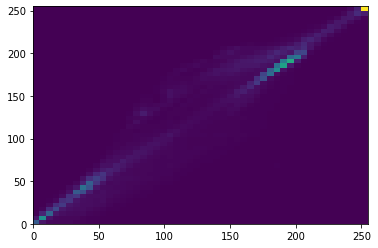

In [6]:
pixel_matrix = np.reshape(first, (dims[0] * dims[1], dims[2]))
print(np.shape(pixel_matrix))
plot.hist2d(pixel_matrix[:,1], pixel_matrix[:,2], bins=(50,50))

<div class="alert alert-block alert-info">
Observe basic property of one image then we we will compute dataset global values. 
</div

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (1080, 1920, 3)
Image Hight 1080
Image Width 1920
Dimension of Image 3
Image size 6220800
Maximum RGB value in this image 255
Minimum RGB value in this image 0


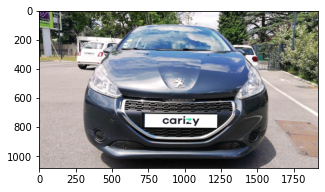

In [7]:
 plot.figure(figsize = (5,5))
 plot.imshow(first)
print('Type of the image : ' , type(first)) 
print('Shape of the image : {}'.format(first.shape)) 
print('Image Hight {}'.format(first.shape[0])) 
print('Image Width {}'.format(first.shape[1])) 
print('Dimension of Image {}'.format(first.ndim))
print('Image size {}'.format(first.size)) 
print('Maximum RGB value in this image {}'.format(first.max()))
print('Minimum RGB value in this image {}'.format(first.min()))  
                                                                                                              
                                                                                                                
                                                                                                                
                                                                                                              

<div class="alert alert-block alert-success">
The shape of the ndarray shows that it is a three-layered matrix. The first two numbers here are length and width, and the third number (i.e. 3) is for three layers: Red, Green, Blue. So, if we calculate the size of an RGB image, the total size will be counted as height x width x 3
</div>

<div class="alert alert-block alert-info">
Okay, now let’s take a quick view of each channel in the whole image.
</div>

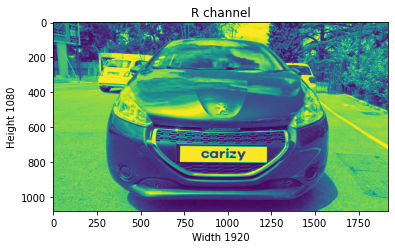

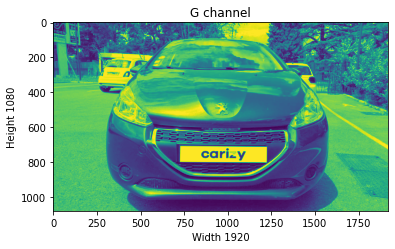

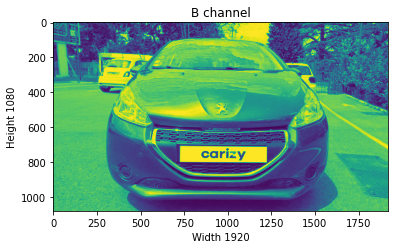

In [8]:
plot.title('R channel') 
plot.ylabel('Height {}'.format(first.shape[0])) 
plot.xlabel('Width {}'.format(first.shape[1])) 
plot.imshow(first[ : , : , 0])
plot.show()
plot.title('G channel')
plot.ylabel('Height {}'.format(first.shape[0])) 
plot.xlabel('Width {}'.format(first.shape[1])) 
plot.imshow(first[ : , : , 1]) 
plot.show()
plot.title('B channel') 
plot.ylabel('Height {}'.format(first.shape[0])) 
plot.xlabel('Width {}'.format(first.shape[1])) 
plot.imshow(first[ : , : , 2]) 
plot.show()

**Splitting layers**
We are looking for an intersting output on a picture to see if it could be better use for model training

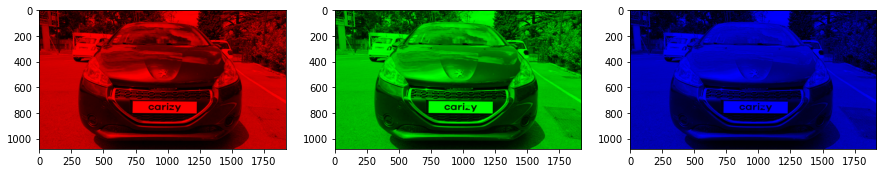

In [9]:
fig, ax = plot.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):     
     # create zero matrix        
     split_img = np.zeros(first.shape, dtype="uint8") 
     # 'dtype' by default: 'numpy.float64'  # assing each channel      
     split_img[ :, :, c] = first[ :, :, c] # display each channel     
     ax.imshow(split_img)

<div class="alert alert-block alert-danger">
Not very interesting. Maybe we could look for a grayscale image. It coulb be used later for computational matters. 
</div>

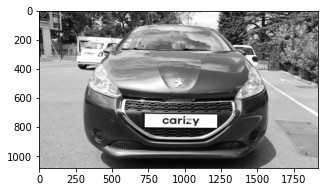

In [10]:
gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114])
gray = gray(first)
plot.figure( figsize = (5,5))  
plot.imshow(gray, cmap = plot.get_cmap(name = 'gray')) 
plot.show()

<div class="alert alert-block alert-info">
The car brand is still recognizable and the logo also. Moreover it reduces the dimension of the np array and it could be a clear advantage to train the model.
</div

<div class="alert alert-block alert-info">
Let's visualize a few image of the dataset just for pleasure.
</div

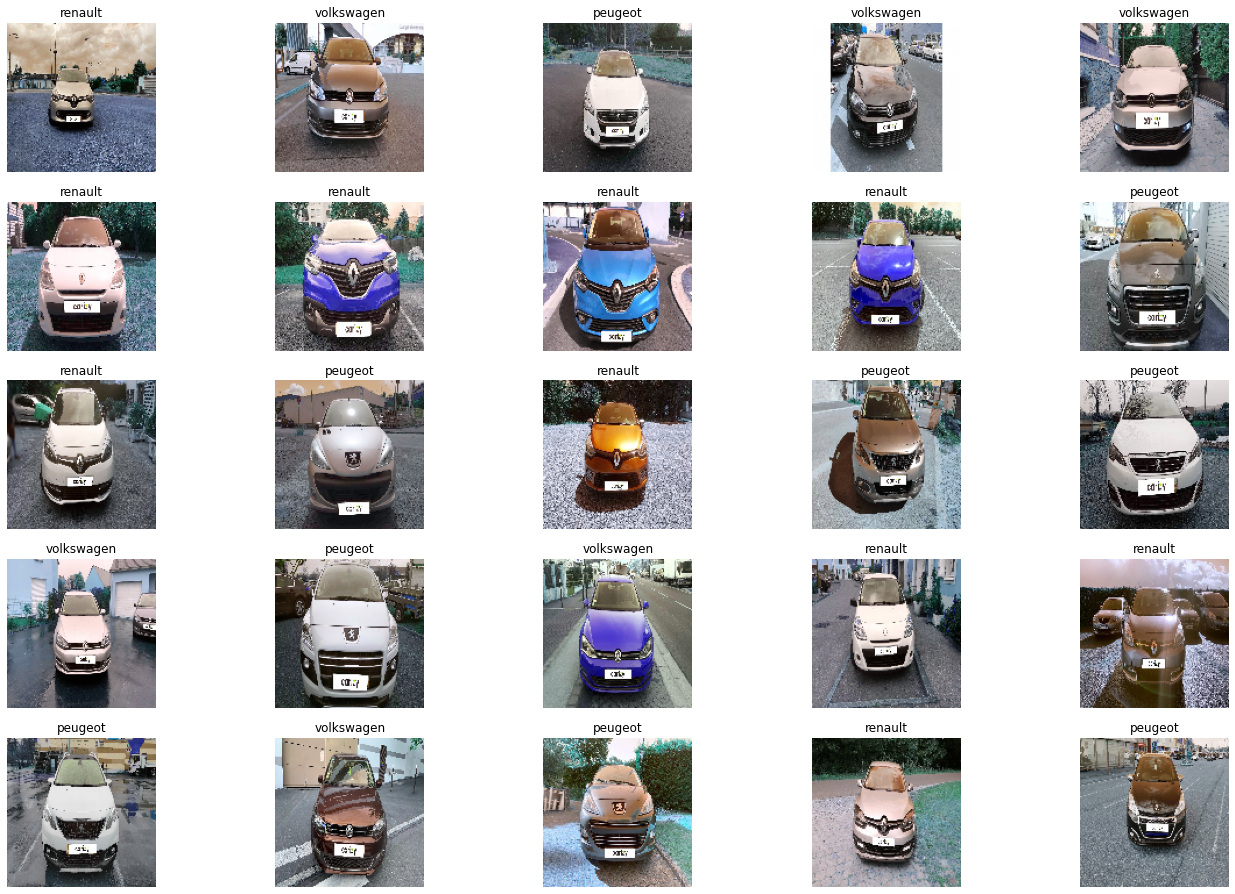

In [11]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(5):
    for j in range(5):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

**Data exploration**
We are now going to visualize the repartition of each car brand with a bar and scatter chart.

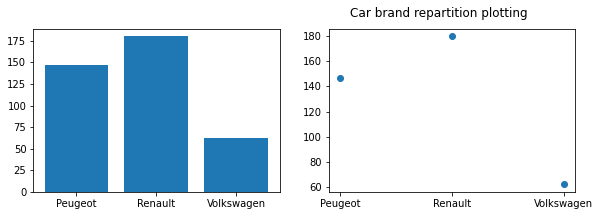

Peugeot : 147 | 37.78%
Renault : 180 | 46.27%
Volkswagen : 62 | 15.93%


In [12]:
unique, counts = np.unique(Labels, return_counts=True)
occurences = np.asarray((unique, counts)).T
names = ['Peugeot', 'Renault', 'Volkswagen']
values = [occurences[0][1], occurences[1][1], occurences[2][1]]
total = Labels.size
plot.figure(figsize=(15, 3))

plot.subplot(131)
plot.bar(names, values)
plot.subplot(132)
plot.scatter(names, values)
plot.suptitle('Car brand repartition plotting')
plot.show()
print("Peugeot : " + str(occurences[0][1]) + " | " + str(int(occurences[0][1] / total * 10000) / 100) + "%")
print("Renault : " + str(occurences[1][1]) + " | " + str(int(occurences[1][1] / total * 10000) / 100) + "%")
print("Volkswagen : " + str(occurences[2][1]) + " | " + str(int(occurences[2][1] / total * 10000) / 100) + "%")


<div class="alert alert-block alert-success">
Regarding those results we are now able to estimate our model efficiency.<br>
If the model predict peugeot less than the random (56.5%) then it won't be good enough. Since it could be prediciting renault each time.
</div>

<a id="datapreprocessing"></a>
## 3. Data pre-processing

Since we have already loaded the data in the Images class and the dataset was already normliazed to 128x128 matrix we will the validation and train set and then label encode the data.

<a id="3.1"></a>
### 3.1 Split training & validation set


<div class="alert alert-block alert-success">
I choosed to split the train set in two parts : a small fraction (20%) became the validation set which the model is evaluated and the rest (80%) is used to train the model. This the safest and classical splitting values.<br>
Moreover i will take <strong>10 pictures</strong> in each brand dataset to put it in a test set directly in the folders.
</div>

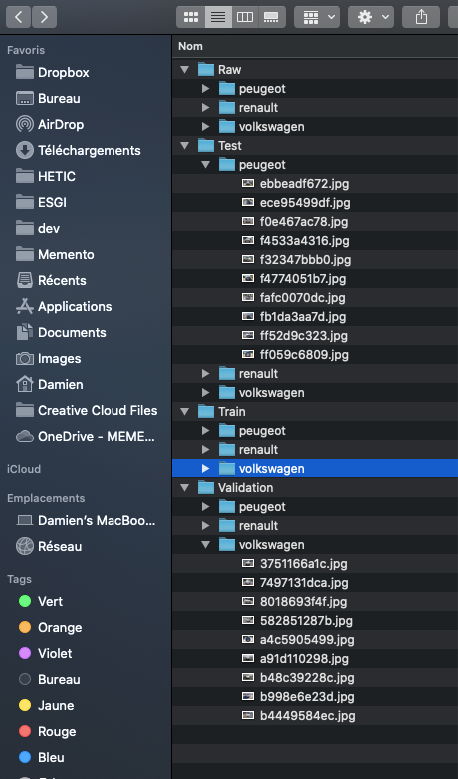

In [13]:
# parameters variable
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "../../Dataset/Train"
validation_dir = "../../Dataset/Validation"
target_width = 128
target_height = 128
color_mode = 'rgb'
target_size = (target_width, target_height)
image_generator = ImageDataGenerator(rescale=1./255)

# Set train data
train_data = image_generator.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode=color_mode,
    )
#set Validation data
validation_data = image_generator.flow_from_directory(
    validation_dir,
    target_size=target_size,
    color_mode=color_mode
)

train_data.batch_size = train_data.n
(x, y) = train_data.next()
train_true_label = np.argmax(y, axis=1)

Found 289 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


<div class="alert alert-block alert-info">
    Perfec the dataset is loaded and and resized to 128x128 pictures
</div>

<a id="3.2"></a>
### 3.2 Label encoding & data prep

Labels are 3 digits numbers from 0 to 2 representing the different classes. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1]).

<div class="alert alert-block alert-info">
    Let's build one hot encoding for labelling our values.
    It's take a form => [0,0,1] where the index correspond to the label of the input.
</div>

<a id="4"></a>
## 4. First neural network training

We are now going to start training our first neural network by using three different models:
* Linear Model
* Multi Layer Perceptron
* Support Vector machine

In [48]:
# Necessary classes for building a correct model and neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

<a id="4.1"></a>
### 4.1 Linear Model

We are now going to build our very first model with one layer neural network whcih represent a linear model. We are not expecting a success since image classification is complex and would need multi layers. Morever the dataset is not that big. We will have to use logistic regression in order to do multi class classfication.

In [ ]:
model = LogisticRegression(solver = 'lbfgs')
model.fit(train_data, train_true_label)

In [ ]:
y_pred = model.predict(validation_data)
# how did our model perform?
count_misclassified = (test_lbl != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_lbl, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))


In [13]:
def predict_linear_classification(W, Xk):     #g(Xk)
  sum = W[0]
  for i in range(Xk.shape[0]):
    sum += W[i + 1] * Xk[i]
  return 1 if sum >=0 else -1

In [12]:
def train_rosenblatt(W, X, Y, nb_iter:int = 100, alpha: float = 0.1):
  for it in range(nb_iter):
    k = np.random.randint(X.shape[0])
    gxk = predict_linear_classification(W, X[k])
    for i in range(X.shape[1]):
      W[i + 1] += alpha * (Y[k] - gxk) * X[k][i]
    W[0] += alpha * (Y[k] - gxk)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 49155     
Total params: 49,155
Trainable params: 49,155
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train the model
linear_model.fit(train_data, epochs=1000, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/basic_linear_128x128")])

Epoch 1/1000


InvalidArgumentError:  Matrix size-incompatible: In[0]: [32,49152], In[1]: [16384,3]
	 [[node sequential_4/dense/BiasAdd (defined at <ipython-input-13-edbbdb243ba6>:2) ]] [Op:__inference_train_function_602]

Function call stack:
train_function


<div class="alert alert-block alert-success">
    We now have a linear neural network with a only layer with softmax ativation function. The input shape is adpated to converted 1D inputs.
</div>

In [15]:
#utility function to show loss in interactive plot
%matplotlib notebook
import matplotlib.pyplot as plot
def plot_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plot.legend()
    plot.grid()
    fig.canvas.draw()

Epoch 1/500
325/325 [==============================] - 0s 2ms/step - loss: 1.1657 - accuracy: 0.4215 - val_loss: 1.0648 - val_accuracy: 0.3780
Epoch 2/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0466 - accuracy: 0.4369 - val_loss: 1.0646 - val_accuracy: 0.3780
Epoch 3/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0432 - accuracy: 0.4369 - val_loss: 1.0656 - val_accuracy: 0.3780
Epoch 4/500
325/325 [==============================] - 0s 979us/step - loss: 1.0420 - accuracy: 0.4369 - val_loss: 1.0679 - val_accuracy: 0.3780
Epoch 5/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0421 - accuracy: 0.4369 - val_loss: 1.0660 - val_accuracy: 0.3780
Epoch 6/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0417 - accuracy: 0.4369 - val_loss: 1.0634 - val_accuracy: 0.3780
Epoch 7/500
325/325 [==============================] - 0s 1000us/step - loss: 1.0422 - accuracy: 0.4369 - val_loss: 1.0659 - val_accuracy: 0

325/325 [==============================] - 0s 975us/step - loss: 1.0422 - accuracy: 0.4369 - val_loss: 1.0658 - val_accuracy: 0.3780
Epoch 114/500
325/325 [==============================] - 0s 968us/step - loss: 1.0420 - accuracy: 0.4369 - val_loss: 1.0645 - val_accuracy: 0.3780
Epoch 115/500
325/325 [==============================] - 0s 971us/step - loss: 1.0419 - accuracy: 0.4369 - val_loss: 1.0649 - val_accuracy: 0.3780
Epoch 116/500
325/325 [==============================] - 0s 976us/step - loss: 1.0421 - accuracy: 0.4369 - val_loss: 1.0669 - val_accuracy: 0.3780
Epoch 117/500
325/325 [==============================] - 0s 969us/step - loss: 1.0417 - accuracy: 0.4369 - val_loss: 1.0644 - val_accuracy: 0.3780
Epoch 118/500
325/325 [==============================] - 0s 973us/step - loss: 1.0415 - accuracy: 0.4308 - val_loss: 1.0686 - val_accuracy: 0.3780
Epoch 119/500
325/325 [==============================] - 0s 965us/step - loss: 1.0421 - accuracy: 0.4369 - val_loss: 1.0668 - val_ac

325/325 [==============================] - 0s 1ms/step - loss: 1.0423 - accuracy: 0.4369 - val_loss: 1.0675 - val_accuracy: 0.3780
Epoch 226/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0419 - accuracy: 0.4369 - val_loss: 1.0670 - val_accuracy: 0.3780
Epoch 227/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0421 - accuracy: 0.4369 - val_loss: 1.0675 - val_accuracy: 0.3780
Epoch 228/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0416 - accuracy: 0.4277 - val_loss: 1.0662 - val_accuracy: 0.3780
Epoch 229/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0415 - accuracy: 0.4369 - val_loss: 1.0645 - val_accuracy: 0.3780
Epoch 230/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0416 - accuracy: 0.4369 - val_loss: 1.0669 - val_accuracy: 0.3780
Epoch 231/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0420 - accuracy: 0.4369 - val_loss: 1.0667 - val_accuracy: 0.3780

325/325 [==============================] - 1s 2ms/step - loss: 1.0421 - accuracy: 0.4369 - val_loss: 1.0655 - val_accuracy: 0.3780
Epoch 338/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0418 - accuracy: 0.4369 - val_loss: 1.0682 - val_accuracy: 0.3780
Epoch 339/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0421 - accuracy: 0.4369 - val_loss: 1.0674 - val_accuracy: 0.3780
Epoch 340/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0417 - accuracy: 0.4369 - val_loss: 1.0648 - val_accuracy: 0.3780
Epoch 341/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0420 - accuracy: 0.4369 - val_loss: 1.0642 - val_accuracy: 0.3780
Epoch 342/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0414 - accuracy: 0.4338 - val_loss: 1.0675 - val_accuracy: 0.3780
Epoch 343/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0419 - accuracy: 0.4369 - val_loss: 1.0648 - val_accuracy: 0.3780

325/325 [==============================] - 0s 1ms/step - loss: 1.0422 - accuracy: 0.4369 - val_loss: 1.0667 - val_accuracy: 0.3780
Epoch 450/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0419 - accuracy: 0.4369 - val_loss: 1.0690 - val_accuracy: 0.3780
Epoch 451/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0419 - accuracy: 0.4369 - val_loss: 1.0692 - val_accuracy: 0.3780
Epoch 452/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0418 - accuracy: 0.4369 - val_loss: 1.0664 - val_accuracy: 0.3780
Epoch 453/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0419 - accuracy: 0.4369 - val_loss: 1.0677 - val_accuracy: 0.3780
Epoch 454/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0420 - accuracy: 0.4369 - val_loss: 1.0664 - val_accuracy: 0.3780
Epoch 455/500
325/325 [==============================] - 0s 1ms/step - loss: 1.0418 - accuracy: 0.4369 - val_loss: 1.0669 - val_accuracy: 0.3780

<IPython.core.display.Javascript object>


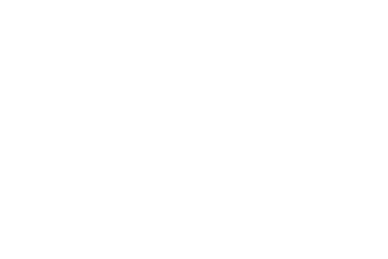

<IPython.core.display.Javascript object>


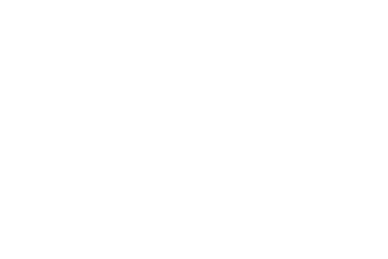

In [29]:
# Train model
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, Y_val))

Test score: 1.0670872926712036
Test accuracy: 0.37804877758026123


<IPython.core.display.Javascript object>


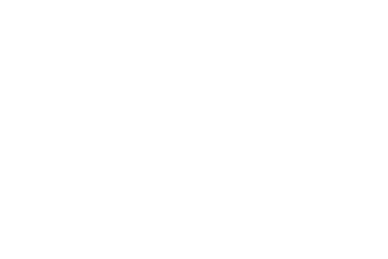

<IPython.core.display.Javascript object>


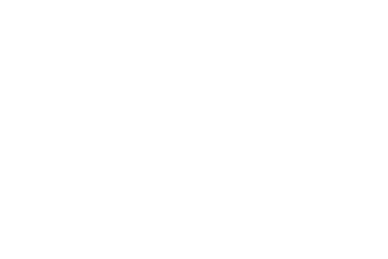

In [32]:
score = model.evaluate(X_val, Y_val, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Categorical Crossentropy Loss"
x= list(range(1, nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_dynamic(x, vy, ty, ax)

<div class="alert alert-block alert-danger">
    Now we show the validation and train loss score and it's clearly bad.
    The most efficient is at <strong>90 epochs</strong> but still this model is clearly not good.
    The model is clearly underfitted.
</div>

<a id="4.2"></a>
### 4.2 Multi Layer Pereceptron

Let's try now with a second type of neural network. We hope for better results.
We will be able tu use the same validation and training set in order to compare the results.

In [24]:
# Build basic MLP model
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(128,128,3)))
mlp_model.add(Dense(256, activation='tanh'))
mlp_model.add(Dense(256, activation='tanh'))
mlp_model.add(Dense(3, activation='softmax'))
mlp_model.compile(loss=tensorflow.keras.losses.mean_squared_error, metrics=['accuracy'])
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               12583168  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 12,649,731
Trainable params: 12,649,731
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train the model
mlp_model.fit(train_data, epochs=20, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/basic_mlp_128x128_rgb_meansquarrederror")])

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.2539 - accuracy: 0.4533 - val_loss: 0.4095 - val_accuracy: 0.3857
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 0.4129 - accuracy: 0.3806 - val_loss: 0.4095 - val_accuracy: 0.3857
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 0.4129 - accuracy: 0.3806 - val_loss: 0.4095 - val_accuracy: 0.3857
Epoch 4/20
1/1 [==============================] - 3s 3s/step - loss: 0.4129 - accuracy: 0.3806 - val_loss: 0.4095 - val_accuracy: 0.3857
Epoch 5/20
1/1 [==============================] - 3s 3s/step - loss: 0.4129 - accuracy: 0.3806 - val_loss: 0.4094 - val_accuracy: 0.3857
Epoch 6/20
1/1 [==============================] - 3s 3s/step - loss: 0.4128 - accuracy: 0.3806 - val_loss: 0.4094 - val_accuracy: 0.3857
Epoch 7/20
1/1 [==============================] - 3s 3s/step - loss: 0.4128 - accuracy: 0.3806 - val_loss: 0.4093 - val_accuracy: 0.3857
Epoch 8/20
1/1 [=========================

<div class="alert alert-block alert-danger">
    Without optimizer the computing is too long and we are really limited with epoch, morever the model underfit really fast (less than 20 epochs)
</div>

In [26]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(128,128,3)))
mlp_model.add(Dense(256, activation='tanh'))
mlp_model.add(Dense(256, activation='tanh'))
mlp_model.add(Dense(3, activation='softmax'))
mlp_model.compile(optimizer='SGD', loss=tensorflow.keras.losses.mean_squared_error, metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               12583168  
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 12,649,731
Trainable params: 12,649,731
Non-trainable params: 0
_________________________________________________________________


<div class="alert alert-block alert-info">
With a optimizer computing get's a bit better 
</div>

In [27]:
# Train the model
mlp_model.fit(train_data, epochs=50, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/sgd_mlp_128x128_rgb_meansquarrederror")])

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.2796 - accuracy: 0.1488 - val_loss: 0.2421 - val_accuracy: 0.4857
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 0.2574 - accuracy: 0.4706 - val_loss: 0.3984 - val_accuracy: 0.3857
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 0.4019 - accuracy: 0.3806 - val_loss: 0.3846 - val_accuracy: 0.3857
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 0.3880 - accuracy: 0.3806 - val_loss: 0.2979 - val_accuracy: 0.3857
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.2997 - accuracy: 0.3806 - val_loss: 0.3307 - val_accuracy: 0.4857
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 0.3406 - accuracy: 0.4706 - val_loss: 0.3174 - val_accuracy: 0.4857
Epoch 7/50
1/1 [==============================] - 3s 3s/step - loss: 0.3269 - accuracy: 0.4706 - val_loss: 0.2582 - val_accuracy: 0.4857
Epoch 8/50
1/1 [=========================

<div class="alert alert-block alert-danger">
The computing is too long so we want to try reduce the input size. Treating data in greyscale seems a good idea. The feature of a car brand is not in it's color but more in it it's shape. In addition since we don't have every car color the coloration can give the models bad intuitions on color.
</div>

In [17]:
#Let's generate the grayscale dataset
train_dir = "../../Dataset/Train"
validation_dir = "../../Dataset/Validation"
target_width = 128
target_height = 128
color_mode = 'grayscale'
target_size = (target_width, target_height)
image_generator = ImageDataGenerator(rescale=1./255)

# Set train data
train_data = image_generator.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode=color_mode,
        #classes=['peugeot', 'renault', 'volkswagen']
    )
#set Validation data
validation_data = image_generator.flow_from_directory(
    validation_dir,
    target_size=target_size,
    color_mode=color_mode
    #classes=['peugeot', 'renault', 'volkswagen']
)

train_data.batch_size = train_data.n
(x, y) = train_data.next()
train_true_label = np.argmax(y, axis=1)
print(train_data.next()[0].shape)

Found 289 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


In [33]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(128,128, 1)))
mlp_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
mlp_model.add(Layers.Dropout(0.5))
mlp_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
mlp_model.add(Layers.Dropout(0.5))
mlp_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
mlp_model.add(Layers.Dropout(0.5))
mlp_model.add(Dense(3, activation='softmax'))

# save the best model according to validation data set accuracy
checkpoint = ModelCheckpoint('../../App/backend/models/mlp_m.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# compile the model
mlp_model.compile(optimizer='SGD', loss=tensorflow.keras.losses.categorical_crossentropy, metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)              

In [ ]:
mlp_model.fit(train_data, batch_size = 32, epochs=500, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/triple512_sgd_relu_dropout_regulizerl2_mlp_128x128_greyscale_categorical-crossentropy"), checkpoint])

Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 3.5256 - accuracy: 0.2630
Epoch 00001: val_accuracy improved from -inf to 0.41429, saving model to ../../App/backend/models/mlp_m.h5
1/1 [==============================] - 3s 3s/step - loss: 3.5256 - accuracy: 0.2630 - val_loss: 3.0412 - val_accuracy: 0.4143
Epoch 2/500
1/1 [==============================] - ETA: 0s - loss: 3.2276 - accuracy: 0.3979
Epoch 00002: val_accuracy improved from 0.41429 to 0.44286, saving model to ../../App/backend/models/mlp_m.h5
1/1 [==============================] - 3s 3s/step - loss: 3.2276 - accuracy: 0.3979 - val_loss: 3.0093 - val_accuracy: 0.4429
Epoch 3/500
1/1 [==============================] - ETA: 0s - loss: 3.1928 - accuracy: 0.4221
Epoch 00003: val_accuracy did not improve from 0.44286
1/1 [==============================] - 3s 3s/step - loss: 3.1928 - accuracy: 0.4221 - val_loss: 3.0112 - val_accuracy: 0.4286
Epoch 4/500
1/1 [==============================] - ETA: 0s - loss: 3.20

1/1 [==============================] - ETA: 0s - loss: 2.9976 - accuracy: 0.4879
Epoch 00030: val_accuracy did not improve from 0.47143
1/1 [==============================] - 3s 3s/step - loss: 2.9976 - accuracy: 0.4879 - val_loss: 3.0156 - val_accuracy: 0.4000
Epoch 31/500
1/1 [==============================] - ETA: 0s - loss: 2.9785 - accuracy: 0.4983
Epoch 00031: val_accuracy did not improve from 0.47143
1/1 [==============================] - 4s 4s/step - loss: 2.9785 - accuracy: 0.4983 - val_loss: 3.0157 - val_accuracy: 0.4143
Epoch 32/500
1/1 [==============================] - ETA: 0s - loss: 3.0035 - accuracy: 0.5052
Epoch 00032: val_accuracy did not improve from 0.47143
1/1 [==============================] - 4s 4s/step - loss: 3.0035 - accuracy: 0.5052 - val_loss: 3.0229 - val_accuracy: 0.3857
Epoch 33/500
1/1 [==============================] - ETA: 0s - loss: 2.9918 - accuracy: 0.5294
Epoch 00033: val_accuracy did not improve from 0.47143
1/1 [==============================] - 

Epoch 60/500
1/1 [==============================] - ETA: 0s - loss: 2.9807 - accuracy: 0.4983
Epoch 00060: val_accuracy did not improve from 0.50000
1/1 [==============================] - 3s 3s/step - loss: 2.9807 - accuracy: 0.4983 - val_loss: 3.0070 - val_accuracy: 0.3857
Epoch 61/500
1/1 [==============================] - ETA: 0s - loss: 2.9791 - accuracy: 0.5225
Epoch 00061: val_accuracy did not improve from 0.50000
1/1 [==============================] - 3s 3s/step - loss: 2.9791 - accuracy: 0.5225 - val_loss: 3.0076 - val_accuracy: 0.4571
Epoch 62/500
1/1 [==============================] - ETA: 0s - loss: 2.9595 - accuracy: 0.4983
Epoch 00062: val_accuracy did not improve from 0.50000
1/1 [==============================] - 3s 3s/step - loss: 2.9595 - accuracy: 0.4983 - val_loss: 3.0080 - val_accuracy: 0.4571
Epoch 63/500
1/1 [==============================] - ETA: 0s - loss: 2.9514 - accuracy: 0.5225
Epoch 00063: val_accuracy did not improve from 0.50000
1/1 [=====================

Epoch 90/500
1/1 [==============================] - ETA: 0s - loss: 2.9077 - accuracy: 0.5606
Epoch 00090: val_accuracy did not improve from 0.50000
1/1 [==============================] - 3s 3s/step - loss: 2.9077 - accuracy: 0.5606 - val_loss: 3.0190 - val_accuracy: 0.3714
Epoch 91/500
1/1 [==============================] - ETA: 0s - loss: 2.9035 - accuracy: 0.6090
Epoch 00091: val_accuracy did not improve from 0.50000
1/1 [==============================] - 3s 3s/step - loss: 2.9035 - accuracy: 0.6090 - val_loss: 3.0122 - val_accuracy: 0.4286
Epoch 92/500
1/1 [==============================] - ETA: 0s - loss: 2.8601 - accuracy: 0.6125
Epoch 00092: val_accuracy did not improve from 0.50000
1/1 [==============================] - 3s 3s/step - loss: 2.8601 - accuracy: 0.6125 - val_loss: 3.0115 - val_accuracy: 0.4143
Epoch 93/500
1/1 [==============================] - ETA: 0s - loss: 2.8909 - accuracy: 0.5675
Epoch 00093: val_accuracy did not improve from 0.50000
1/1 [=====================

Epoch 120/500
1/1 [==============================] - ETA: 0s - loss: 2.8212 - accuracy: 0.6125
Epoch 00120: val_accuracy did not improve from 0.52857
1/1 [==============================] - 3s 3s/step - loss: 2.8212 - accuracy: 0.6125 - val_loss: 3.0158 - val_accuracy: 0.4429
Epoch 121/500
1/1 [==============================] - ETA: 0s - loss: 2.8199 - accuracy: 0.6194
Epoch 00121: val_accuracy did not improve from 0.52857
1/1 [==============================] - 4s 4s/step - loss: 2.8199 - accuracy: 0.6194 - val_loss: 3.0106 - val_accuracy: 0.4857
Epoch 122/500
1/1 [==============================] - ETA: 0s - loss: 2.8671 - accuracy: 0.5606
Epoch 00122: val_accuracy did not improve from 0.52857
1/1 [==============================] - 3s 3s/step - loss: 2.8671 - accuracy: 0.5606 - val_loss: 3.0083 - val_accuracy: 0.4571
Epoch 123/500
1/1 [==============================] - ETA: 0s - loss: 2.8399 - accuracy: 0.5986
Epoch 00123: val_accuracy did not improve from 0.52857
1/1 [=================

Epoch 150/500
1/1 [==============================] - ETA: 0s - loss: 2.8118 - accuracy: 0.6505
Epoch 00150: val_accuracy did not improve from 0.55714
1/1 [==============================] - 3s 3s/step - loss: 2.8118 - accuracy: 0.6505 - val_loss: 3.0312 - val_accuracy: 0.3857
Epoch 151/500
1/1 [==============================] - ETA: 0s - loss: 2.8128 - accuracy: 0.6298
Epoch 00151: val_accuracy did not improve from 0.55714
1/1 [==============================] - 3s 3s/step - loss: 2.8128 - accuracy: 0.6298 - val_loss: 3.0385 - val_accuracy: 0.5429
Epoch 152/500
1/1 [==============================] - ETA: 0s - loss: 2.7897 - accuracy: 0.6228
Epoch 00152: val_accuracy did not improve from 0.55714
1/1 [==============================] - 3s 3s/step - loss: 2.7897 - accuracy: 0.6228 - val_loss: 3.0511 - val_accuracy: 0.3714
Epoch 153/500
1/1 [==============================] - ETA: 0s - loss: 2.8486 - accuracy: 0.6125
Epoch 00153: val_accuracy did not improve from 0.55714
1/1 [=================

Epoch 180/500
1/1 [==============================] - ETA: 0s - loss: 2.8114 - accuracy: 0.5813
Epoch 00180: val_accuracy did not improve from 0.55714
1/1 [==============================] - 3s 3s/step - loss: 2.8114 - accuracy: 0.5813 - val_loss: 3.0412 - val_accuracy: 0.3571
Epoch 181/500
1/1 [==============================] - ETA: 0s - loss: 2.7798 - accuracy: 0.6436
Epoch 00181: val_accuracy did not improve from 0.55714
1/1 [==============================] - 3s 3s/step - loss: 2.7798 - accuracy: 0.6436 - val_loss: 3.0427 - val_accuracy: 0.5429
Epoch 182/500
1/1 [==============================] - ETA: 0s - loss: 2.7472 - accuracy: 0.6747
Epoch 00182: val_accuracy did not improve from 0.55714
1/1 [==============================] - 3s 3s/step - loss: 2.7472 - accuracy: 0.6747 - val_loss: 3.0342 - val_accuracy: 0.4143
Epoch 183/500
1/1 [==============================] - ETA: 0s - loss: 2.7248 - accuracy: 0.6851
Epoch 00183: val_accuracy did not improve from 0.55714
1/1 [=================

Epoch 210/500
1/1 [==============================] - ETA: 0s - loss: 2.7219 - accuracy: 0.6471
Epoch 00210: val_accuracy did not improve from 0.55714
1/1 [==============================] - 5s 5s/step - loss: 2.7219 - accuracy: 0.6471 - val_loss: 3.1308 - val_accuracy: 0.4143
Epoch 211/500
1/1 [==============================] - ETA: 0s - loss: 2.7675 - accuracy: 0.6540
Epoch 00211: val_accuracy did not improve from 0.55714
1/1 [==============================] - 4s 4s/step - loss: 2.7675 - accuracy: 0.6540 - val_loss: 3.1224 - val_accuracy: 0.4714
Epoch 212/500
1/1 [==============================] - ETA: 0s - loss: 2.7724 - accuracy: 0.5952
Epoch 00212: val_accuracy did not improve from 0.55714
1/1 [==============================] - 5s 5s/step - loss: 2.7724 - accuracy: 0.5952 - val_loss: 3.0718 - val_accuracy: 0.3857
Epoch 213/500
1/1 [==============================] - ETA: 0s - loss: 2.7522 - accuracy: 0.6609
Epoch 00213: val_accuracy did not improve from 0.55714
1/1 [=================

Epoch 240/500
1/1 [==============================] - ETA: 0s - loss: 2.8266 - accuracy: 0.5848
Epoch 00240: val_accuracy did not improve from 0.57143
1/1 [==============================] - 3s 3s/step - loss: 2.8266 - accuracy: 0.5848 - val_loss: 3.1551 - val_accuracy: 0.4000
Epoch 241/500
1/1 [==============================] - ETA: 0s - loss: 2.7909 - accuracy: 0.6055
Epoch 00241: val_accuracy did not improve from 0.57143
1/1 [==============================] - 4s 4s/step - loss: 2.7909 - accuracy: 0.6055 - val_loss: 3.0179 - val_accuracy: 0.5429
Epoch 242/500
1/1 [==============================] - ETA: 0s - loss: 2.6988 - accuracy: 0.6817
Epoch 00242: val_accuracy did not improve from 0.57143
1/1 [==============================] - 3s 3s/step - loss: 2.6988 - accuracy: 0.6817 - val_loss: 3.0427 - val_accuracy: 0.3714
Epoch 243/500
1/1 [==============================] - ETA: 0s - loss: 2.6371 - accuracy: 0.7751
Epoch 00243: val_accuracy did not improve from 0.57143
1/1 [=================

Epoch 270/500
1/1 [==============================] - ETA: 0s - loss: 2.6315 - accuracy: 0.7197
Epoch 00270: val_accuracy did not improve from 0.57143
1/1 [==============================] - 3s 3s/step - loss: 2.6315 - accuracy: 0.7197 - val_loss: 3.3086 - val_accuracy: 0.4143
Epoch 271/500
1/1 [==============================] - ETA: 0s - loss: 2.7680 - accuracy: 0.5917
Epoch 00271: val_accuracy did not improve from 0.57143
1/1 [==============================] - 4s 4s/step - loss: 2.7680 - accuracy: 0.5917 - val_loss: 3.3057 - val_accuracy: 0.4714
Epoch 272/500
1/1 [==============================] - ETA: 0s - loss: 2.8292 - accuracy: 0.5779
Epoch 00272: val_accuracy did not improve from 0.57143
1/1 [==============================] - 4s 4s/step - loss: 2.8292 - accuracy: 0.5779 - val_loss: 3.0616 - val_accuracy: 0.4000
Epoch 273/500
1/1 [==============================] - ETA: 0s - loss: 2.6902 - accuracy: 0.7474
Epoch 00273: val_accuracy did not improve from 0.57143
1/1 [=================

Epoch 300/500
1/1 [==============================] - ETA: 0s - loss: 2.5195 - accuracy: 0.7958
Epoch 00300: val_accuracy did not improve from 0.57143
1/1 [==============================] - 3s 3s/step - loss: 2.5195 - accuracy: 0.7958 - val_loss: 3.2157 - val_accuracy: 0.5429
Epoch 301/500
1/1 [==============================] - ETA: 0s - loss: 2.5112 - accuracy: 0.7785
Epoch 00301: val_accuracy did not improve from 0.57143
1/1 [==============================] - 4s 4s/step - loss: 2.5112 - accuracy: 0.7785 - val_loss: 3.3106 - val_accuracy: 0.3857
Epoch 302/500
1/1 [==============================] - ETA: 0s - loss: 2.6580 - accuracy: 0.7128
Epoch 00302: val_accuracy did not improve from 0.57143
1/1 [==============================] - 4s 4s/step - loss: 2.6580 - accuracy: 0.7128 - val_loss: 3.5223 - val_accuracy: 0.4571
Epoch 303/500
1/1 [==============================] - ETA: 0s - loss: 2.8498 - accuracy: 0.5779
Epoch 00303: val_accuracy did not improve from 0.57143
1/1 [=================

Epoch 330/500
1/1 [==============================] - ETA: 0s - loss: 2.7205 - accuracy: 0.6125
Epoch 00330: val_accuracy did not improve from 0.57143
1/1 [==============================] - 3s 3s/step - loss: 2.7205 - accuracy: 0.6125 - val_loss: 3.1534 - val_accuracy: 0.4000
Epoch 331/500
1/1 [==============================] - ETA: 0s - loss: 2.6258 - accuracy: 0.7716
Epoch 00331: val_accuracy did not improve from 0.57143
1/1 [==============================] - 4s 4s/step - loss: 2.6258 - accuracy: 0.7716 - val_loss: 3.1282 - val_accuracy: 0.5000
Epoch 332/500
1/1 [==============================] - ETA: 0s - loss: 2.5492 - accuracy: 0.7543
Epoch 00332: val_accuracy did not improve from 0.57143
1/1 [==============================] - 3s 3s/step - loss: 2.5492 - accuracy: 0.7543 - val_loss: 3.1597 - val_accuracy: 0.4000
Epoch 333/500
1/1 [==============================] - ETA: 0s - loss: 2.5042 - accuracy: 0.8062
Epoch 00333: val_accuracy did not improve from 0.57143
1/1 [=================

Epoch 360/500
1/1 [==============================] - ETA: 0s - loss: 2.7455 - accuracy: 0.6471
Epoch 00360: val_accuracy did not improve from 0.57143
1/1 [==============================] - 3s 3s/step - loss: 2.7455 - accuracy: 0.6471 - val_loss: 3.3690 - val_accuracy: 0.3857
Epoch 361/500
1/1 [==============================] - ETA: 0s - loss: 2.7933 - accuracy: 0.5744
Epoch 00361: val_accuracy did not improve from 0.57143
1/1 [==============================] - 3s 3s/step - loss: 2.7933 - accuracy: 0.5744 - val_loss: 3.0869 - val_accuracy: 0.5143
Epoch 362/500
1/1 [==============================] - ETA: 0s - loss: 2.5394 - accuracy: 0.8304
Epoch 00362: val_accuracy did not improve from 0.57143
1/1 [==============================] - 3s 3s/step - loss: 2.5394 - accuracy: 0.8304 - val_loss: 3.1151 - val_accuracy: 0.3714
Epoch 363/500
1/1 [==============================] - ETA: 0s - loss: 2.4269 - accuracy: 0.8824
Epoch 00363: val_accuracy did not improve from 0.57143
1/1 [=================

Epoch 390/500
1/1 [==============================] - ETA: 0s - loss: 2.3864 - accuracy: 0.8824
Epoch 00390: val_accuracy did not improve from 0.58571
1/1 [==============================] - 4s 4s/step - loss: 2.3864 - accuracy: 0.8824 - val_loss: 3.2786 - val_accuracy: 0.3571
Epoch 391/500
1/1 [==============================] - ETA: 0s - loss: 2.3828 - accuracy: 0.8754
Epoch 00391: val_accuracy did not improve from 0.58571
1/1 [==============================] - 4s 4s/step - loss: 2.3828 - accuracy: 0.8754 - val_loss: 3.3097 - val_accuracy: 0.5000
Epoch 392/500
1/1 [==============================] - ETA: 0s - loss: 2.4464 - accuracy: 0.8339
Epoch 00392: val_accuracy did not improve from 0.58571
1/1 [==============================] - 5s 5s/step - loss: 2.4464 - accuracy: 0.8339 - val_loss: 3.4524 - val_accuracy: 0.3714
Epoch 393/500
1/1 [==============================] - ETA: 0s - loss: 2.4741 - accuracy: 0.7474
Epoch 00393: val_accuracy did not improve from 0.58571
1/1 [=================

Epoch 420/500
1/1 [==============================] - ETA: 0s - loss: 2.3904 - accuracy: 0.8374
Epoch 00420: val_accuracy did not improve from 0.58571
1/1 [==============================] - 4s 4s/step - loss: 2.3904 - accuracy: 0.8374 - val_loss: 3.4355 - val_accuracy: 0.3857
Epoch 421/500
1/1 [==============================] - ETA: 0s - loss: 2.4869 - accuracy: 0.7785
Epoch 00421: val_accuracy did not improve from 0.58571
1/1 [==============================] - 3s 3s/step - loss: 2.4869 - accuracy: 0.7785 - val_loss: 3.5688 - val_accuracy: 0.4714
Epoch 422/500
1/1 [==============================] - ETA: 0s - loss: 2.5490 - accuracy: 0.7163
Epoch 00422: val_accuracy did not improve from 0.58571
1/1 [==============================] - 3s 3s/step - loss: 2.5490 - accuracy: 0.7163 - val_loss: 3.4277 - val_accuracy: 0.4000
Epoch 423/500
1/1 [==============================] - ETA: 0s - loss: 2.6285 - accuracy: 0.6678
Epoch 00423: val_accuracy did not improve from 0.58571
1/1 [=================

Epoch 450/500
1/1 [==============================] - ETA: 0s - loss: 2.5476 - accuracy: 0.7197
Epoch 00450: val_accuracy did not improve from 0.58571
1/1 [==============================] - 3s 3s/step - loss: 2.5476 - accuracy: 0.7197 - val_loss: 3.3175 - val_accuracy: 0.3857
Epoch 451/500
1/1 [==============================] - ETA: 0s - loss: 2.4729 - accuracy: 0.7820
Epoch 00451: val_accuracy did not improve from 0.58571
1/1 [==============================] - 3s 3s/step - loss: 2.4729 - accuracy: 0.7820 - val_loss: 3.2909 - val_accuracy: 0.4714
Epoch 452/500
1/1 [==============================] - ETA: 0s - loss: 2.3711 - accuracy: 0.8685
Epoch 00452: val_accuracy did not improve from 0.58571
1/1 [==============================] - 3s 3s/step - loss: 2.3711 - accuracy: 0.8685 - val_loss: 3.2842 - val_accuracy: 0.3714
Epoch 453/500
1/1 [==============================] - ETA: 0s - loss: 2.2865 - accuracy: 0.9273
Epoch 00453: val_accuracy did not improve from 0.58571
1/1 [=================

Epoch 480/500
1/1 [==============================] - ETA: 0s - loss: 2.2549 - accuracy: 0.9273
Epoch 00480: val_accuracy did not improve from 0.58571
1/1 [==============================] - 3s 3s/step - loss: 2.2549 - accuracy: 0.9273 - val_loss: 3.4748 - val_accuracy: 0.3571
Epoch 481/500
1/1 [==============================] - ETA: 0s - loss: 2.2718 - accuracy: 0.9273
Epoch 00481: val_accuracy did not improve from 0.58571
1/1 [==============================] - 3s 3s/step - loss: 2.2718 - accuracy: 0.9273 - val_loss: 3.4612 - val_accuracy: 0.4857
Epoch 482/500
1/1 [==============================] - ETA: 0s - loss: 2.3028 - accuracy: 0.8962
Epoch 00482: val_accuracy did not improve from 0.58571
1/1 [==============================] - 4s 4s/step - loss: 2.3028 - accuracy: 0.8962 - val_loss: 3.6273 - val_accuracy: 0.3857
Epoch 483/500
1/1 [==============================] - ETA: 0s - loss: 2.3478 - accuracy: 0.8339
Epoch 00483: val_accuracy did not improve from 0.58571
1/1 [=================

In [ ]:
train_data.batch_size = train_data.n
    (x, y) = train_data.next()
    preds = model.predict(x)
    train_preds_label = np.argmax(preds, axis=1)
    train_true_label = np.argmax(y, axis=1)

    validation_data.batch_size = validation_data.n
    (x, y) = validation_data.next()
    preds = model.predict(x)
    validation_preds_label = np.argmax(preds, axis=1)
    validation_true_label = np.argmax(y, axis=1)

    print("Training Set Confusion Matrix : ")
    print(CM(train_true_label, train_preds_label))

    print("Validation Set Confusion Matrix : ")
    print(CM(validation_true_label, validation_preds_label))

## Data augmentation
In order to improve the datset that is not big enough for geenralization we will proceed to data augmentation:
* First we will change the zoom on each image since usually the center of the image is where the car is situated
* Then we will proceed to horizontal flip since it is not changing the car features
* A few egrees rotation won't change the brand features neither
* Will shift the image horizontally and vertically in order to create better stregn to the model

In [17]:
#Let's generate the augmented dataset
train_dir = "../../Dataset/Train"
validation_dir = "../../Dataset/Validation"
target_width = 128
target_height = 128
color_mode = 'grayscale'
target_size = (target_width, target_height)
image_generator = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.30,#Zooming
                                     horizontal_flip=True,
                                     rotation_range=10,
                                     width_shift_range=0.2, #Horizontal shifting
                                     height_shift_range=0.2)#vertical shifting

# Set train data
train_data = image_generator.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode=color_mode,
        #classes=['peugeot', 'renault', 'volkswagen']
    )
#set Validation data
validation_data = image_generator.flow_from_directory(
    validation_dir,
    target_size=target_size,
    color_mode=color_mode
    #classes=['peugeot', 'renault', 'volkswagen']
)

train_data.batch_size = train_data.n
(x, y) = train_data.next()
train_true_label = np.argmax(y, axis=1)


Found 289 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


Test score: 1.1455484628677368
Test accuracy: 0.23170731961727142
Epoch 1/500
325/325 [==============================] - 1s 2ms/step - loss: 1.1364 - accuracy: 0.4123 - val_loss: 1.0898 - val_accuracy: 0.3780
Epoch 2/500
325/325 [==============================] - 1s 2ms/step - loss: 1.1109 - accuracy: 0.3754 - val_loss: 1.1422 - val_accuracy: 0.3780
Epoch 3/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0921 - accuracy: 0.3815 - val_loss: 1.0881 - val_accuracy: 0.4146
Epoch 4/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0752 - accuracy: 0.4123 - val_loss: 1.0504 - val_accuracy: 0.4634
Epoch 5/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0747 - accuracy: 0.4154 - val_loss: 1.1204 - val_accuracy: 0.3780
Epoch 6/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0665 - accuracy: 0.4092 - val_loss: 1.1307 - val_accuracy: 0.3780
Epoch 7/500
325/325 [==============================] - 1s 2ms/step - loss: 1

Epoch 114/500
325/325 [==============================] - 1s 2ms/step - loss: 0.4407 - accuracy: 0.8185 - val_loss: 1.8401 - val_accuracy: 0.4268
Epoch 115/500
325/325 [==============================] - 1s 2ms/step - loss: 0.5637 - accuracy: 0.8031 - val_loss: 2.5849 - val_accuracy: 0.4146
Epoch 116/500
325/325 [==============================] - 1s 2ms/step - loss: 0.8083 - accuracy: 0.6277 - val_loss: 1.2476 - val_accuracy: 0.3171
Epoch 117/500
325/325 [==============================] - 1s 2ms/step - loss: 0.7944 - accuracy: 0.6554 - val_loss: 1.2850 - val_accuracy: 0.4390
Epoch 118/500
325/325 [==============================] - 1s 2ms/step - loss: 0.8064 - accuracy: 0.6431 - val_loss: 1.5470 - val_accuracy: 0.3780
Epoch 119/500
325/325 [==============================] - 1s 2ms/step - loss: 0.7257 - accuracy: 0.6338 - val_loss: 1.2828 - val_accuracy: 0.4634
Epoch 120/500
325/325 [==============================] - 1s 2ms/step - loss: 0.8442 - accuracy: 0.5877 - val_loss: 1.0952 - val_ac

325/325 [==============================] - 1s 2ms/step - loss: 1.0466 - accuracy: 0.4154 - val_loss: 1.0738 - val_accuracy: 0.3780
Epoch 227/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0469 - accuracy: 0.4308 - val_loss: 1.0702 - val_accuracy: 0.3780
Epoch 228/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0467 - accuracy: 0.4185 - val_loss: 1.0632 - val_accuracy: 0.3780
Epoch 229/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0468 - accuracy: 0.4185 - val_loss: 1.0634 - val_accuracy: 0.3780
Epoch 230/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0444 - accuracy: 0.4246 - val_loss: 1.0765 - val_accuracy: 0.3780
Epoch 231/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0467 - accuracy: 0.4215 - val_loss: 1.0689 - val_accuracy: 0.3780
Epoch 232/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0452 - accuracy: 0.4246 - val_loss: 1.0749 - val_accuracy: 0.3780

325/325 [==============================] - 1s 2ms/step - loss: 1.0461 - accuracy: 0.4154 - val_loss: 1.0624 - val_accuracy: 0.3780
Epoch 339/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0450 - accuracy: 0.4338 - val_loss: 1.0634 - val_accuracy: 0.3780
Epoch 340/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0439 - accuracy: 0.4092 - val_loss: 1.0732 - val_accuracy: 0.3780
Epoch 341/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0443 - accuracy: 0.4246 - val_loss: 1.0751 - val_accuracy: 0.3780
Epoch 342/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0444 - accuracy: 0.4369 - val_loss: 1.0627 - val_accuracy: 0.3659
Epoch 343/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0432 - accuracy: 0.4400 - val_loss: 1.0708 - val_accuracy: 0.3780
Epoch 344/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0441 - accuracy: 0.4215 - val_loss: 1.0745 - val_accuracy: 0.3780

325/325 [==============================] - 1s 2ms/step - loss: 1.0435 - accuracy: 0.4369 - val_loss: 1.0616 - val_accuracy: 0.3780
Epoch 451/500
325/325 [==============================] - 1s 3ms/step - loss: 1.0402 - accuracy: 0.4338 - val_loss: 1.0764 - val_accuracy: 0.3780
Epoch 452/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0438 - accuracy: 0.4369 - val_loss: 1.0655 - val_accuracy: 0.3780
Epoch 453/500
325/325 [==============================] - 1s 3ms/step - loss: 1.0424 - accuracy: 0.4215 - val_loss: 1.0623 - val_accuracy: 0.3780
Epoch 454/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0426 - accuracy: 0.4308 - val_loss: 1.0684 - val_accuracy: 0.3780
Epoch 455/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0404 - accuracy: 0.4092 - val_loss: 1.0821 - val_accuracy: 0.3780
Epoch 456/500
325/325 [==============================] - 1s 2ms/step - loss: 1.0423 - accuracy: 0.4246 - val_loss: 1.0651 - val_accuracy: 0.3780

<IPython.core.display.Javascript object>


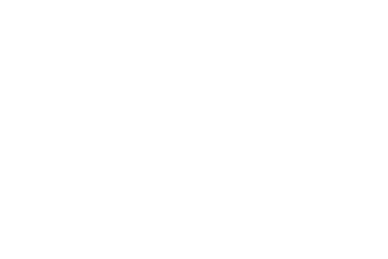

<IPython.core.display.Javascript object>


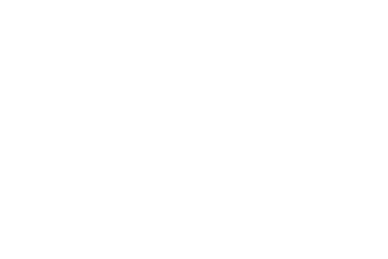

In [34]:
# Now that we have augmented the datset let's create the model
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(128,128, 1)))
mlp_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
mlp_model.add(Layers.Dropout(0.5))
mlp_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
mlp_model.add(Layers.Dropout(0.5))
mlp_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
mlp_model.add(Layers.Dropout(0.5))
mlp_model.add(Dense(3, activation='softmax'))

# save the best model according to validation data set accuracy
checkpoint = ModelCheckpoint('../../App/backend/models/mlp_m1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# compile the model
mlp_model.compile(optimizer='SGD', loss=tensorflow.keras.losses.categorical_crossentropy, metrics=['accuracy'])
mlp_model.summary()


In [ ]:
hitory = mlp_model.fit(train_data, batch_size = 32, epochs=100, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/1024x512x128x32_augmented_sgd_relu_dropout_mlp_128x128_greyscale_categorical-crossentropy"), checkpoint])



In [16]:
#Plot the loss
score = mlp_model.evaluate(X_val, Y_val, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Categorical Crossentropy Loss"
x= list(range(1, nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_dynamic(x, vy, ty, ax)

NameError: name 'model' is not defined

In [ ]:
train_data.batch_size = train_data.n
(x, y) = train_data.next()
preds = mlp_model.predict(x)
train_preds_label = np.argmax(preds, axis=1)
train_true_label = np.argmax(y, axis=1)

validation_data.batch_size = validation_data.n
(x, y) = validation_data.next()
preds = mlp_model.predict(x)
validation_preds_label = np.argmax(preds, axis=1)
validation_true_label = np.argmax(y, axis=1)

print("Training Set Confusion Matrix : ")
print(confusion_matrix(train_true_label, train_preds_label))

print("Validation Set Confusion Matrix : ")
print(confusion_matrix(validation_true_label, validation_preds_label))

<div class="alert alert-block alert-success">
We have reached a 57% accuracy on the validation which is slightly better than random. The model predict too much Renault according the confusion matrices. That is due to its over representation in the dataset.
</div>

<a id="4.3"></a>
### 4.3 Support Vector Machine

We don't have good enough result will try adding a SVM (regulizer in Keras) to improve the model and reduce overfitting

In [37]:
print(train_data.next()[0].shape)

(289, 128, 128, 1)


In [38]:
# Now that we have augmented the datset let's create the model
svm_model = Sequential()

svm_model.add(Flatten(input_shape=(128,128, 1)))
svm_model.add(Dense(1024, activation='relu', ))# Regularizer are the SVM implementation in Keras
svm_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
svm_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
svm_model.add(Dense(3, activation='softmax'))

# save the best model according to validation data set accuracy
checkpoint = ModelCheckpoint('../../App/backend/models/svm_m2.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

svm_model.build((289, 128, 128, 1))
# compile the model
svm_model.compile(optimizer='SGD', loss=tensorflow.keras.losses.mean_squared_error, metrics=['categorical_accuracy'])
svm_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           multiple                  80        
_________________________________________________________________
max_pooling2d_21 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_22 (Conv2D)           multiple                  1168      
_________________________________________________________________
max_pooling2d_22 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_23 (Conv2D)           multiple                  4640      
_________________________________________________________________
max_pooling2d_23 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_15 (Flatten)         multiple                

In [39]:
history = svm_model.fit(train_data, batch_size = 32, epochs=200, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/1024x512x128x32_augmented_sgd_relu_maxpool_conv_regulizerl2_svm_l2_0.01_128x128_greyscale_categorical-crossentropy"), checkpoint])


Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.5533 - categorical_accuracy: 0.4014 - val_loss: 0.5540 - val_categorical_accuracy: 0.2857
Epoch 2/200
1/1 [==============================] - 3s 3s/step - loss: 0.5530 - categorical_accuracy: 0.4083 - val_loss: 0.5524 - val_categorical_accuracy: 0.4714
Epoch 3/200
1/1 [==============================] - 3s 3s/step - loss: 0.5526 - categorical_accuracy: 0.4152 - val_loss: 0.5524 - val_categorical_accuracy: 0.4000
Epoch 4/200
1/1 [==============================] - 3s 3s/step - loss: 0.5521 - categorical_accuracy: 0.4671 - val_loss: 0.5519 - val_categorical_accuracy: 0.4286
Epoch 5/200
1/1 [==============================] - 3s 3s/step - loss: 0.5520 - categorical_accuracy: 0.4152 - val_loss: 0.5520 - val_categorical_accuracy: 0.4143
Epoch 6/200
1/1 [==============================] - 3s 3s/step - loss: 0.5515 - categorical_accuracy: 0.4637 - val_loss: 0.5513 - val_categorical_accuracy: 0.4143
Epoch 7/200
1/1 [===========

1/1 [==============================] - 4s 4s/step - loss: 0.5453 - categorical_accuracy: 0.4394 - val_loss: 0.5436 - val_categorical_accuracy: 0.4857
Epoch 26/200
1/1 [==============================] - 4s 4s/step - loss: 0.5447 - categorical_accuracy: 0.4567 - val_loss: 0.5437 - val_categorical_accuracy: 0.4857
Epoch 27/200
1/1 [==============================] - 3s 3s/step - loss: 0.5440 - categorical_accuracy: 0.4671 - val_loss: 0.5427 - val_categorical_accuracy: 0.4571
Epoch 28/200
1/1 [==============================] - 4s 4s/step - loss: 0.5438 - categorical_accuracy: 0.4671 - val_loss: 0.5432 - val_categorical_accuracy: 0.4143
Epoch 29/200
1/1 [==============================] - 4s 4s/step - loss: 0.5435 - categorical_accuracy: 0.4637 - val_loss: 0.5420 - val_categorical_accuracy: 0.5286
Epoch 30/200
1/1 [==============================] - 4s 4s/step - loss: 0.5431 - categorical_accuracy: 0.4810 - val_loss: 0.5423 - val_categorical_accuracy: 0.4857
Epoch 31/200
1/1 [=================

1/1 [==============================] - 4s 4s/step - loss: 0.5377 - categorical_accuracy: 0.4706 - val_loss: 0.5357 - val_categorical_accuracy: 0.5000
Epoch 50/200
1/1 [==============================] - 4s 4s/step - loss: 0.5373 - categorical_accuracy: 0.4706 - val_loss: 0.5353 - val_categorical_accuracy: 0.4857
Epoch 51/200
1/1 [==============================] - 4s 4s/step - loss: 0.5369 - categorical_accuracy: 0.4706 - val_loss: 0.5362 - val_categorical_accuracy: 0.4714
Epoch 52/200
1/1 [==============================] - 4s 4s/step - loss: 0.5362 - categorical_accuracy: 0.4706 - val_loss: 0.5352 - val_categorical_accuracy: 0.4857
Epoch 53/200
1/1 [==============================] - 4s 4s/step - loss: 0.5365 - categorical_accuracy: 0.4706 - val_loss: 0.5344 - val_categorical_accuracy: 0.4857
Epoch 54/200
1/1 [==============================] - 4s 4s/step - loss: 0.5360 - categorical_accuracy: 0.4706 - val_loss: 0.5344 - val_categorical_accuracy: 0.4857
Epoch 55/200
1/1 [=================

1/1 [==============================] - 3s 3s/step - loss: 0.5313 - categorical_accuracy: 0.4706 - val_loss: 0.5291 - val_categorical_accuracy: 0.4857
Epoch 74/200
1/1 [==============================] - 3s 3s/step - loss: 0.5311 - categorical_accuracy: 0.4706 - val_loss: 0.5285 - val_categorical_accuracy: 0.4857
Epoch 75/200
1/1 [==============================] - 3s 3s/step - loss: 0.5309 - categorical_accuracy: 0.4706 - val_loss: 0.5289 - val_categorical_accuracy: 0.4857
Epoch 76/200
1/1 [==============================] - 3s 3s/step - loss: 0.5311 - categorical_accuracy: 0.4706 - val_loss: 0.5288 - val_categorical_accuracy: 0.4857
Epoch 77/200
1/1 [==============================] - 3s 3s/step - loss: 0.5305 - categorical_accuracy: 0.4706 - val_loss: 0.5278 - val_categorical_accuracy: 0.4857
Epoch 78/200
1/1 [==============================] - 3s 3s/step - loss: 0.5303 - categorical_accuracy: 0.4706 - val_loss: 0.5279 - val_categorical_accuracy: 0.4857
Epoch 79/200
1/1 [=================

1/1 [==============================] - 3s 3s/step - loss: 0.5266 - categorical_accuracy: 0.4706 - val_loss: 0.5242 - val_categorical_accuracy: 0.4857
Epoch 98/200
1/1 [==============================] - 3s 3s/step - loss: 0.5259 - categorical_accuracy: 0.4706 - val_loss: 0.5241 - val_categorical_accuracy: 0.4857
Epoch 99/200
1/1 [==============================] - 3s 3s/step - loss: 0.5260 - categorical_accuracy: 0.4706 - val_loss: 0.5223 - val_categorical_accuracy: 0.4857
Epoch 100/200
1/1 [==============================] - 3s 3s/step - loss: 0.5258 - categorical_accuracy: 0.4706 - val_loss: 0.5224 - val_categorical_accuracy: 0.4857
Epoch 101/200
1/1 [==============================] - 5s 5s/step - loss: 0.5255 - categorical_accuracy: 0.4706 - val_loss: 0.5229 - val_categorical_accuracy: 0.4857
Epoch 102/200
1/1 [==============================] - 4s 4s/step - loss: 0.5254 - categorical_accuracy: 0.4706 - val_loss: 0.5231 - val_categorical_accuracy: 0.4857
Epoch 103/200
1/1 [=============

1/1 [==============================] - 3s 3s/step - loss: 0.5221 - categorical_accuracy: 0.4706 - val_loss: 0.5183 - val_categorical_accuracy: 0.4857
Epoch 122/200
1/1 [==============================] - 3s 3s/step - loss: 0.5220 - categorical_accuracy: 0.4706 - val_loss: 0.5199 - val_categorical_accuracy: 0.4857
Epoch 123/200
1/1 [==============================] - 3s 3s/step - loss: 0.5219 - categorical_accuracy: 0.4706 - val_loss: 0.5177 - val_categorical_accuracy: 0.4857
Epoch 124/200
1/1 [==============================] - 3s 3s/step - loss: 0.5217 - categorical_accuracy: 0.4706 - val_loss: 0.5190 - val_categorical_accuracy: 0.4857
Epoch 125/200
1/1 [==============================] - 3s 3s/step - loss: 0.5214 - categorical_accuracy: 0.4706 - val_loss: 0.5186 - val_categorical_accuracy: 0.4857
Epoch 126/200
1/1 [==============================] - 3s 3s/step - loss: 0.5213 - categorical_accuracy: 0.4706 - val_loss: 0.5180 - val_categorical_accuracy: 0.4857
Epoch 127/200
1/1 [===========

1/1 [==============================] - 3s 3s/step - loss: 0.5187 - categorical_accuracy: 0.4706 - val_loss: 0.5146 - val_categorical_accuracy: 0.4857
Epoch 146/200
1/1 [==============================] - 3s 3s/step - loss: 0.5186 - categorical_accuracy: 0.4706 - val_loss: 0.5161 - val_categorical_accuracy: 0.4857
Epoch 147/200
1/1 [==============================] - 3s 3s/step - loss: 0.5181 - categorical_accuracy: 0.4706 - val_loss: 0.5146 - val_categorical_accuracy: 0.4857
Epoch 148/200
1/1 [==============================] - 3s 3s/step - loss: 0.5181 - categorical_accuracy: 0.4706 - val_loss: 0.5150 - val_categorical_accuracy: 0.4857
Epoch 149/200
1/1 [==============================] - 3s 3s/step - loss: 0.5180 - categorical_accuracy: 0.4706 - val_loss: 0.5146 - val_categorical_accuracy: 0.4857
Epoch 150/200
1/1 [==============================] - 3s 3s/step - loss: 0.5180 - categorical_accuracy: 0.4706 - val_loss: 0.5147 - val_categorical_accuracy: 0.4857
Epoch 151/200
1/1 [===========

1/1 [==============================] - 3s 3s/step - loss: 0.5151 - categorical_accuracy: 0.4706 - val_loss: 0.5125 - val_categorical_accuracy: 0.4857
Epoch 170/200
1/1 [==============================] - 3s 3s/step - loss: 0.5149 - categorical_accuracy: 0.4706 - val_loss: 0.5103 - val_categorical_accuracy: 0.4857
Epoch 171/200
1/1 [==============================] - 3s 3s/step - loss: 0.5150 - categorical_accuracy: 0.4706 - val_loss: 0.5122 - val_categorical_accuracy: 0.4857
Epoch 172/200
1/1 [==============================] - 3s 3s/step - loss: 0.5151 - categorical_accuracy: 0.4706 - val_loss: 0.5115 - val_categorical_accuracy: 0.4857
Epoch 173/200
1/1 [==============================] - 3s 3s/step - loss: 0.5147 - categorical_accuracy: 0.4706 - val_loss: 0.5102 - val_categorical_accuracy: 0.4857
Epoch 174/200
1/1 [==============================] - 3s 3s/step - loss: 0.5147 - categorical_accuracy: 0.4706 - val_loss: 0.5108 - val_categorical_accuracy: 0.4857
Epoch 175/200
1/1 [===========

1/1 [==============================] - 3s 3s/step - loss: 0.5120 - categorical_accuracy: 0.4706 - val_loss: 0.5083 - val_categorical_accuracy: 0.4857
Epoch 194/200
1/1 [==============================] - 3s 3s/step - loss: 0.5122 - categorical_accuracy: 0.4706 - val_loss: 0.5091 - val_categorical_accuracy: 0.4857
Epoch 195/200
1/1 [==============================] - 3s 3s/step - loss: 0.5117 - categorical_accuracy: 0.4706 - val_loss: 0.5083 - val_categorical_accuracy: 0.4857
Epoch 196/200
1/1 [==============================] - 3s 3s/step - loss: 0.5116 - categorical_accuracy: 0.4706 - val_loss: 0.5080 - val_categorical_accuracy: 0.4857
Epoch 197/200
1/1 [==============================] - 3s 3s/step - loss: 0.5114 - categorical_accuracy: 0.4706 - val_loss: 0.5081 - val_categorical_accuracy: 0.4857
Epoch 198/200
1/1 [==============================] - 3s 3s/step - loss: 0.5113 - categorical_accuracy: 0.4706 - val_loss: 0.5081 - val_categorical_accuracy: 0.4857
Epoch 199/200
1/1 [===========

In [ ]:
#Plot the loss
score = mlp_model.evaluate(X_val, Y_val, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
fig, ax = plot.subplots(1,1)
ax.set_xlabel = "epoch"
ax.set_ylabel = "Categorical Crossentropy Loss"
x= list(range(1, nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_dynamic(x, vy, ty, ax)

In [ ]:
train_data.batch_size = train_data.n
(x, y) = train_data.next()
preds = svm_model.predict(x)
train_preds_label = np.argmax(preds, axis=1)
train_true_label = np.argmax(y, axis=1)

validation_data.batch_size = validation_data.n
(x, y) = validation_data.next()
preds = svm_model.predict(x)
validation_preds_label = np.argmax(preds, axis=1)
validation_true_label = np.argmax(y, axis=1)

print("Training Set Confusion Matrix : ")
print(confusion_matrix(train_true_label, train_preds_label))

print("Validation Set Confusion Matrix : ")
print(confusion_matrix(validation_true_label, validation_preds_label))

<a id="4.4"></a>
### 4.4 Convolutional Neural Network

The most efficient model for computer vision is know as convolutional neural network which will try to train to get some results.

In [47]:
#Let's generate the augmented dataset
train_dir = "../../Dataset/Train"
validation_dir = "../../Dataset/Validation"
target_width = 128
target_height = 128
color_mode = 'grayscale'
target_size = (target_width, target_height)
image_generator = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.30,#Zooming
                                     horizontal_flip=True,
                                     rotation_range=10,
                                     width_shift_range=0.2, #Horizontal shifting
                                     height_shift_range=0.2)#vertical shifting

validation_generator = ImageDataGenerator(rescale=1./255)

# Set train data
train_data = image_generator.flow_from_directory(
        train_dir,
        target_size=target_size,
        color_mode=color_mode,
    )
#set Validation data
validation_data = validation_generator.flow_from_directory(
    validation_dir,
    target_size=target_size,
    color_mode=color_mode
)

train_data.batch_size = train_data.n
(x, y) = train_data.next()
train_true_label = np.argmax(y, axis=1)


Found 289 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


In [49]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (128,128,1)))
cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
cnn_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnn_model.add(Dropout(0.25))

# the model so far outputs 3D feature maps (height, width, features)
#On top of it we stick two fully-connected layers. We end the model with a single 

cnn_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
cnn_model.add(Dense(256))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(3))
cnn_model.add(Activation('softmax'))

# save the best model according to validation data set accuracy
checkpoint = ModelCheckpoint('../../App/backend/models/cnn_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# compile the model
cnn_model.compile(optimizer='SGD', loss=tensorflow.keras.losses.mean_squared_error, metrics=['accuracy'])
cnn_model.summary()






Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 128, 128, 32)      832       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 64)      

In [ ]:
history = cnn_model.fit(train_data, batch_size = 32, epochs=250, validation_data=validation_data,
              callbacks=[tensorflow.keras.callbacks.TensorBoard(
                  log_dir="../Results/Logs/cnn_32x64_relu_softmax"), checkpoint])


Epoch 1/250
1/1 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.3633
Epoch 00001: val_accuracy improved from -inf to 0.41429, saving model to ../../App/backend/models/cnn_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.2218 - accuracy: 0.3633 - val_loss: 0.2178 - val_accuracy: 0.4143
Epoch 2/250
1/1 [==============================] - ETA: 0s - loss: 0.2155 - accuracy: 0.4083
Epoch 00002: val_accuracy improved from 0.41429 to 0.45714, saving model to ../../App/backend/models/cnn_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.2155 - accuracy: 0.4083 - val_loss: 0.2157 - val_accuracy: 0.4571
Epoch 3/250
1/1 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.4256
Epoch 00003: val_accuracy improved from 0.45714 to 0.51429, saving model to ../../App/backend/models/cnn_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.2142 - accuracy: 0.4256 - val_loss: 0.2140 - val_accuracy: 0.5143
Epoc

1/1 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.4602
Epoch 00030: val_accuracy did not improve from 0.51429
1/1 [==============================] - 5s 5s/step - loss: 0.2065 - accuracy: 0.4602 - val_loss: 0.2028 - val_accuracy: 0.4857
Epoch 31/250
1/1 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.4567
Epoch 00031: val_accuracy did not improve from 0.51429
1/1 [==============================] - 6s 6s/step - loss: 0.2052 - accuracy: 0.4567 - val_loss: 0.2026 - val_accuracy: 0.4857
Epoch 32/250
1/1 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.4637
Epoch 00032: val_accuracy did not improve from 0.51429
1/1 [==============================] - 5s 5s/step - loss: 0.2049 - accuracy: 0.4637 - val_loss: 0.2026 - val_accuracy: 0.4857
Epoch 33/250
1/1 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.4983
Epoch 00033: val_accuracy did not improve from 0.51429
1/1 [==============================] - 

Epoch 60/250
1/1 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.4844
Epoch 00060: val_accuracy did not improve from 0.51429
1/1 [==============================] - 5s 5s/step - loss: 0.2030 - accuracy: 0.4844 - val_loss: 0.2025 - val_accuracy: 0.4857
Epoch 61/250
1/1 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.4602
Epoch 00061: val_accuracy did not improve from 0.51429
1/1 [==============================] - 5s 5s/step - loss: 0.2029 - accuracy: 0.4602 - val_loss: 0.2024 - val_accuracy: 0.4857
Epoch 62/250
1/1 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.4533
Epoch 00062: val_accuracy did not improve from 0.51429
1/1 [==============================] - 5s 5s/step - loss: 0.2057 - accuracy: 0.4533 - val_loss: 0.2025 - val_accuracy: 0.4857
Epoch 63/250
1/1 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.4602
Epoch 00063: val_accuracy did not improve from 0.51429
1/1 [=====================

Epoch 90/250
1/1 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.4602
Epoch 00090: val_accuracy did not improve from 0.51429
1/1 [==============================] - 4s 4s/step - loss: 0.2027 - accuracy: 0.4602 - val_loss: 0.2027 - val_accuracy: 0.4857
Epoch 91/250
1/1 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.4879
Epoch 00091: val_accuracy did not improve from 0.51429
1/1 [==============================] - 4s 4s/step - loss: 0.2003 - accuracy: 0.4879 - val_loss: 0.2028 - val_accuracy: 0.4857
Epoch 92/250
1/1 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.4464
Epoch 00092: val_accuracy did not improve from 0.51429
1/1 [==============================] - 5s 5s/step - loss: 0.2055 - accuracy: 0.4464 - val_loss: 0.2028 - val_accuracy: 0.4857
Epoch 93/250
1/1 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.4498
Epoch 00093: val_accuracy did not improve from 0.51429
1/1 [=====================

Epoch 120/250
1/1 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.4464
Epoch 00120: val_accuracy did not improve from 0.51429
1/1 [==============================] - 4s 4s/step - loss: 0.2038 - accuracy: 0.4464 - val_loss: 0.2031 - val_accuracy: 0.5000
Epoch 121/250
1/1 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.4810
Epoch 00121: val_accuracy did not improve from 0.51429
1/1 [==============================] - 4s 4s/step - loss: 0.2053 - accuracy: 0.4810 - val_loss: 0.2031 - val_accuracy: 0.5000
Epoch 122/250
1/1 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.4602
Epoch 00122: val_accuracy did not improve from 0.51429
1/1 [==============================] - 4s 4s/step - loss: 0.2032 - accuracy: 0.4602 - val_loss: 0.2032 - val_accuracy: 0.5000
Epoch 123/250
1/1 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.4879
Epoch 00123: val_accuracy did not improve from 0.51429
1/1 [=================

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
train_data.batch_size = train_data.n
(x, y) = train_data.next()
preds = cnn_model.predict(x)
train_preds_label = np.argmax(preds, axis=1)
train_true_label = np.argmax(y, axis=1)

validation_data.batch_size = validation_data.n
(x, y) = validation_data.next()
preds = cnn_model.predict(x)
validation_preds_label = np.argmax(preds, axis=1)
validation_true_label = np.argmax(y, axis=1)

print("Training Set Confusion Matrix : ")
print(confusion_matrix(train_true_label, train_preds_label))

print("Validation Set Confusion Matrix : ")
print(confusion_matrix(validation_true_label, validation_preds_label))